#Загрузка данных

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install category_encoders

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
#import category_encoders
import numpy as np
from sklearn.metrics import log_loss, roc_auc_score

In [3]:
data = pd.read_csv('/content/drive/MyDrive/recsys/data.csv')
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,5664530014561852622,0,0,0,1240,0.067,0.035016,-7.268846,0,0.010,0.049516,-5.369901,1,1
1,2021-09-26 22:54:49.000000,1,1,5186611064559013950,0,0,1,1,0.002,0.054298,-2.657477,269,0.004,0.031942,-4.449220,1,1
2,2021-09-26 23:57:20.000000,2,2,2215519569292448030,3,0,0,2,0.014,0.014096,-3.824875,21,0.014,0.014906,-3.939309,1,1
3,2021-09-27 00:04:30.000000,3,3,6262169206735077204,0,1,1,3,0.012,0.015232,-3.461357,99,0.006,0.050671,-3.418403,1,1
4,2021-09-27 00:06:21.000000,4,4,4778985830203613115,0,1,0,4,0.019,0.051265,-4.009026,11464230,6.790,0.032005,-2.828797,1,1


In [4]:
# убираем дубликаты из датасета
data.drop_duplicates(keep='first', inplace=True, ignore_index=True)

In [5]:
#убираем неиспользуемые колонки
data.drop(columns=['oaid_hash', 'banner_id0', 'banner_id1', 'rate0', 'rate1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1'], inplace=True)
data.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,0,0,0,1,1
1,2021-09-26 22:54:49.000000,1,1,0,0,1,1,1
2,2021-09-26 23:57:20.000000,2,2,3,0,0,1,1
3,2021-09-27 00:04:30.000000,3,3,0,1,1,1,1
4,2021-09-27 00:06:21.000000,4,4,0,1,0,1,1


#Анализ данных и уже имеющихся фичей

1) date_time - время показа рекламы

2) zone_id - id зоны, где зона - место на сайте для размещения рекламы

3) banner_id - id баннера, где баннер - сама реклама

4) campaign_clicks - общее количество показов данной кампании (которой соотвествует баннер) данному юзеру, произошедшие до текущего показа. Кампанию стоит понимать как что-то общее (рекламодатель/тематика/ и т. п.) для баннеров.

5) os_id - id операционной системы

6) country_id - id страны

7) impressions - был ли показ

8) clicks - был ли клик


In [6]:
# проверяем, есть ли отсутствующие значения в данных, считая количество null-ов
data.isnull().values.any()

False

In [7]:
# смотрим на описательные статистики для значений в колонках
data.describe()

,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
count,1.581184e+07,1.581184e+07,1.581184e+07,1.581184e+07,1.581184e+07,15811841.0,1.581184e+07
mean,8.153366e+01,3.816682e+02,6.236193e-01,1.840384e+00,4.346895e+00,1.0,2.640072e-02
std,1.632586e+02,3.959499e+02,9.248393e+00,1.530083e+00,4.317775e+00,0.0,1.603238e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00
25%,1.400000e+01,5.200000e+01,0.000000e+00,1.000000e+00,0.000000e+00,1.0,0.000000e+00
50%,1.900000e+01,2.170000e+02,0.000000e+00,2.000000e+00,4.000000e+00,1.0,0.000000e+00
75%,6.000000e+01,6.110000e+02,0.000000e+00,3.000000e+00,7.000000e+00,1.0,0.000000e+00
max,3.443000e+03,1.632000e+03,8.290000e+02,1.000000e+01,1.600000e+01,1.0,1.000000e+00


Видим, что значение impressions - это константа => нужно выкинуть эту колонку. Нужно внимательнее посмотреть на остальные фичи и распределения их значений.

In [6]:
#убираем колонку impressions
data.drop(columns=['impressions'], inplace=True)

## zone_id

17      2278255
14      1637564
12       735868
0        708260
19       693121
         ...   
2186          1
2188          1
2518          1
2962          1
3443          1
Name: zone_id, Length: 3444, dtype: int64


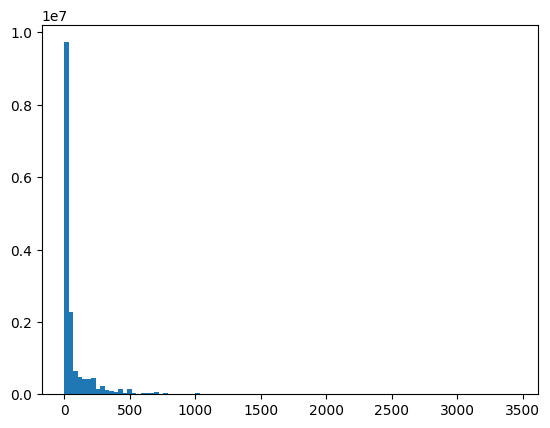

In [ ]:
print(data['zone_id'].value_counts())
plt.hist(data['zone_id'], bins=100)
plt.show()

Видим, что есть как и очень популярные зоны, так и очень редкие, встречающиеся по одному разу. По сути имеем категориальную фичу с большим количеством категорий, нужно будет применить техники уменьшения размерности, например, hashing trick

In [ ]:
for value, count in data['zone_id'].value_counts().items():
  print(f"id = {value}, count = {count}")

##banner_id

22      613230
361     387324
3       286891
18      262848
21      246069
         ...  
1501         1
1503         1
1504         1
1507         1
1632         1
Name: banner_id, Length: 1633, dtype: int64


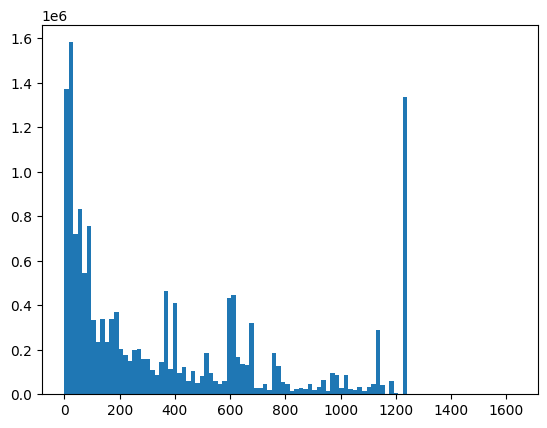

In [ ]:
print(data['banner_id'].value_counts())
plt.hist(data['banner_id'], bins=100)
plt.show()

Тут тоже видим редкие banner_id.

In [ ]:
for value, count in data['banner_id'].value_counts().items():
  print(f"id = {value}, count = {count}")

##campaign_clicks

0      13674351
1       1236020
2        342680
3        173411
4        100219
         ...   
791           1
829           1
820           1
803           1
828           1
Name: campaign_clicks, Length: 822, dtype: int64


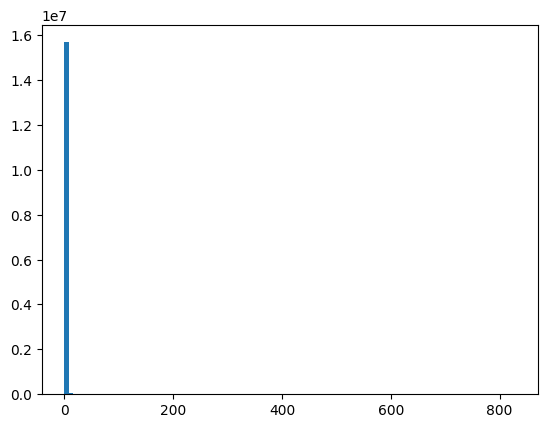

In [ ]:
print(data['campaign_clicks'].value_counts())
plt.hist(data['campaign_clicks'], bins=100)
plt.show()

Это числовая, а не категориальная фича, нужно нормализовать ее

##os_id

In [ ]:
data['os_id'].value_counts()

2     4585585
0     3855517
1     3177765
4     3011011
3      758593
6      310110
5      111859
8        1272
7          99
9          25
10          5
Name: os_id, dtype: int64

Видим, что это категориальная фича c маленьким количеством фичей.Применим one-hot-encoding. Можно объединить 7, 8, 9, 10 лейблы в одну
категорию 'other', так как для них примеров значительно меньше, чем для остальных категорий.

##country_id

In [ ]:
data['country_id'].value_counts()

0     4953404
5     1908101
6     1581894
7     1524483
1     1345737
3     1336892
15     602956
12     477813
9      438747
4      388714
10     356178
11     212106
8      210086
13     190786
14     138313
16      79113
2       66518
Name: country_id, dtype: int64

Тоже категориальная фича => one-hot-encoding

##date_time

In [ ]:
#смотрим, как данные распределены по отдельным дням
pd.to_datetime(data['date_time']).dt.date.value_counts()

2021-09-26    3100783
2021-09-29    2419164
2021-09-27    2365722
2021-09-28    2305758
2021-10-02    2127795
2021-09-30    1850061
2021-10-01    1642557
2021-09-01          1
Name: date_time, dtype: int64

Видим, что последняя дата 2021-09-01 явно лишняя в выборке и попала сюда как-то случайно, так как остальные даты идут последовательно друг за другом, уберем этот пример из датасета.

По условию, в тестовой выборке будут данные данные этого дня 2021-10-02

In [7]:
#добавляем колонку дата показа
data['date'] = pd.to_datetime(data['date_time']).dt.date

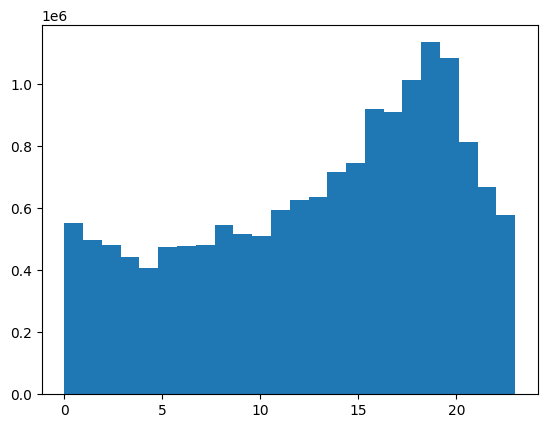

In [ ]:
#смотрим, как данные распределены по отдельным часам
pd.to_datetime(data['date_time']).dt.hour.value_counts()
plt.hist(pd.to_datetime(data['date_time']).dt.hour, bins=24)
plt.show()

Мне кажется, есть смысл попробовать взять в качестве фичи время, в которое была показана реклама, потому что поведение человека меняется в течение дня, что влияет на контент, который ему интересен в текущий момент (например, в среднем,днем люди заняты работой или учебой, а вечером и ночью они отдыхают, просматривают соцсети и тд => с большей вероятностью кликнут на заинтересовавшую их рекламу)

In [8]:
#добавляем колонку время показа
data['hour'] = pd.to_datetime(data['date_time']).dt.hour

In [9]:
#убираем колонку date_time
data.drop(columns = ['date_time'], inplace=True)

##correlation matrix
На всякий случай, проверим, что у нас нет явной коррелирующих фичей

In [ ]:
data.corr()

<ipython-input-12-c44ded798807>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,zone_id,banner_id,campaign_clicks,os_id,country_id,clicks,hour
zone_id,1.000000,-0.035969,0.105945,0.004388,0.146192,-0.024367,0.053508
banner_id,-0.035969,1.000000,-0.029271,0.040470,-0.126676,-0.051285,-0.054051
campaign_clicks,0.105945,-0.029271,1.000000,0.050249,0.058939,-0.004198,-0.002407
os_id,0.004388,0.040470,0.050249,1.000000,0.040358,0.041822,-0.015798
country_id,0.146192,-0.126676,0.058939,0.040358,1.000000,-0.003510,0.185578
clicks,-0.024367,-0.051285,-0.004198,0.041822,-0.003510,1.000000,0.005440
hour,0.053508,-0.054051,-0.002407,-0.015798,0.185578,0.005440,1.000000


видим, что коэффициенты корреляции довольно маленькие, поэтому между фичами нет какой-то явной линейно зависимости => можно брать все фичи.

#Feature engineering


У меня не получилось нормально закодировать фичи для zone_id и banner_id с помощью hashing trick или one-hot-encoding с последующим отбором фичей, потому что мне не хватило оперативной памяти колаба или компьютера для этого. Я применила к этим фичам frequency encoding, но модель с ним будет работать не так хорошо, как хотелось бы

In [11]:
zone_id_freqs = (data.groupby('zone_id').size()) / len(data)
data['zone_id'] = data['zone_id'].apply(lambda x : zone_id_freqs[x])

In [12]:
banner_id_freqs = (data.groupby('banner_id').size()) / len(data)
data['banner_id'] = data['banner_id'].apply(lambda x : banner_id_freqs[x])

In [13]:
#разделим данные на обучающую и тестовую выборки
test_date = data['date'].max()
train_data = data[data['date'] != test_date]
test_data = data[data['date'] == test_date]

In [9]:
print(len(train_data))
print(len(test_data))

13692494
2128978


In [14]:
y_train = train_data['clicks']
X_train = train_data.drop(columns=['clicks', 'date'])
#del train_data

In [15]:
y_test = test_data['clicks']
X_test = test_data.drop(columns=['clicks', 'date'])
#del test_data

In [16]:
del data
del train_data
del test_data

In [14]:
import gc

gc.collect()

0

In [ ]:
#Мне не хватило оперативной памяти, чтобы применить этот энкодер к данным

#from category_encoders import HashingEncoder

#Применяем hashing trick  к категориям, у которых много значений
#Можно улучшить, подобрав гиперпараметр n_components кросс-валидацией
#hash_cols = ['zone_id', 'banner_id']
#hash_enc = HashingEncoder(cols=hash_cols, n_components=100)

#hashing_enc = hash_enc.fit_transform(X_train)
#X_test = hash_enc.transform(X_test)

In [17]:
from sklearn.preprocessing import OneHotEncoder

categories = ['os_id', 'country_id']
one_hot_enc = OneHotEncoder(
    sparse_output=True,
    handle_unknown='ignore',
    min_frequency=100,
    )

X_train_categorical = one_hot_enc.fit_transform(X_train[categories])
X_test_categorical = one_hot_enc.transform(X_test[categories])

In [18]:
X_train_categorical.shape

(13684046, 26)

In [19]:
X_train_numerical = X_train[['campaign_clicks', 'hour', 'zone_id', 'banner_id']]
X_test_numerical = X_test[['campaign_clicks', 'hour', 'zone_id', 'banner_id']]

In [20]:
from scipy.sparse import hstack

X_train = hstack([X_train_categorical, X_train_numerical])
X_test = hstack([X_test_categorical, X_test_numerical])

In [21]:
del X_train_categorical
del X_test_categorical
del X_train_numerical
del X_test_numerical

#Baseline

In [ ]:
mean_value = y_train.mean()
y_pred = [mean_value] * len(y_test)
logloss = log_loss(y_test, y_pred)
print(f"baseline logloss: {logloss}")
auc = roc_auc_score(y_test, y_pred)
print(f"baseline auc: {auc}")

baseline logloss: 0.15407879603434949
baseline auc: 0.5


#Обучение модели и подбор гиперпараметров с помощью-кроссвалидации

В качестве модели возьмем логистическую регрессию с l2-регуляризацией

In [22]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    solver = 'liblinear'
)

In [23]:
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [24]:
y_pred = model.predict(X_test)

In [25]:
logloss = log_loss(y_test, y_pred)
print(f"logloss: {logloss}")
auc = roc_auc_score(y_test, y_pred)
print(f"auc: {auc}")

logloss: 1.2669683929070366
auc: 0.5
